# Explicabilidad

## Introducción

En este notebook utilizaremos Grad-CAM. Un algoritmo que permite visualizar mediante un mapa de saliencias, el efecto en la gradiente respecto a una categoría especifica, hacia una capa interna del modelo.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision.transforms import v2 as transforms
from torchvision.transforms import Compose
from torchvision.models import resnet34, ResNet34_Weights


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [2]:
### Parametros Iniciales

# Si tu equipo contiene una GPU con CUDA:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU disponible')
# Si tu equipo es mac con AppleSilicon:
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Acelerador MPS disponible')
# O en CPU como la plebe:
else:
    device = torch.device('cpu')
    print('CPU disponible')

GPU disponible


(-0.5, 899.5, 899.5, -0.5)

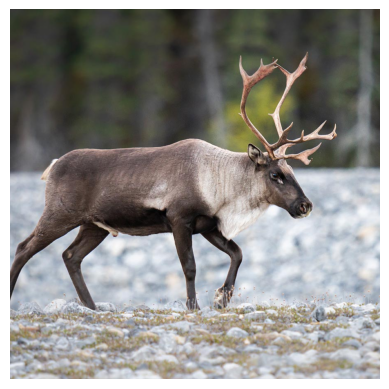

In [3]:
path = '../caribou.jpg'

# Cargamos la imagen
imagen = Image.open(path)

# Visualizamos en matplotlib
plt.imshow(imagen)
plt.axis('off')

In [5]:
transformaciones = Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Preprocesamos la imagen
image_tensor = transformaciones(imagen).unsqueeze(0).to(device)

## Cargar modelo

In [6]:
# Cargamos el modelo
pesos = ResNet34_Weights.DEFAULT # Si uno pone el string "Default" es lo mismo
modelo = resnet34(weights=pesos).to(device)
modelo.eval()


print(modelo)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Grad-CAM

In [7]:
# Para usar Grad-CAM debemos identificar la capa que queremos estudiar.
capa_a_estudiar = [modelo.layer4[2]]
# Junto con definir el target.
# grad-cam tiene un objeto que se encarga de preparar (internamente retorna un corte del tensor de salida en la clase especifica)
targets = [ClassifierOutputTarget(350)] # Clase Ibex en nuestro caso


In [9]:
# Creamos el objeto GradCAM
cam = GradCAM(model=modelo, target_layers=capa_a_estudiar)


In [10]:
# Generamos la visualización
output = cam(input_tensor=image_tensor, targets=targets)
print(output.shape)

(1, 224, 224)


(-0.5, 223.5, 223.5, -0.5)

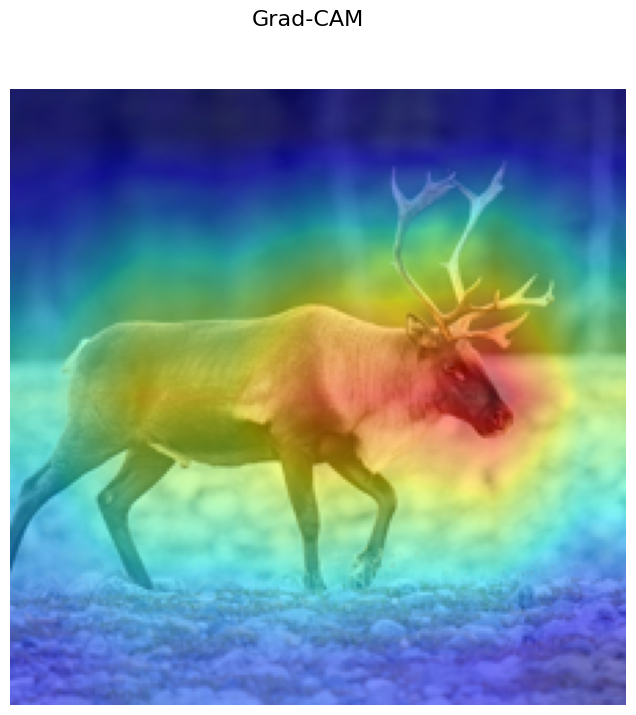

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('Grad-CAM', fontsize=16)
imresized = imagen.resize((224, 224)) # Redimensionamos la imagen para que sea del mismo tamaño que la salida de Grad-CAM
ax.imshow(imresized)
ax.imshow(output[0,:], alpha=0.5, cmap='jet')
ax.axis('off')

Podemos ver en las zonas mas activadas las regiones donde el modelo enfocaba para hacer su decisión.